# Laboratorio 2: Armado de un esquema de aprendizaje automático

En el laboratorio final se espera que puedan poner en práctica los conocimientos adquiridos en el curso, trabajando con un conjunto de datos de clasificación.

El objetivo es que se introduzcan en el desarrollo de un esquema para hacer tareas de aprendizaje automático: selección de un modelo, ajuste de hiperparámetros y evaluación.

El conjunto de datos a utilizar está en `./data/loan_data.csv`. Si abren el archivo verán que al principio (las líneas que empiezan con `#`) describen el conjunto de datos y sus atributos (incluyendo el atributo de etiqueta o clase).

Se espera que hagan uso de las herramientas vistas en el curso. Se espera que hagan uso especialmente de las herramientas brindadas por `scikit-learn`.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

# TODO: Agregar las librerías que hagan falta
from random import sample
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
    ParameterSampler,
)
from sklearn.tree import (
    DecisionTreeClassifier,
    plot_tree, 
    export_graphviz,
)
import graphviz 
from scipy.stats import loguniform
from sklearn.metrics import (
    precision_score,
    recall_score,
    accuracy_score,
    f1_score,
    confusion_matrix,
    classification_report
)

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Etiqueta correcta')
    plt.xlabel('Etiqueta predicha')
    plt.show()

## Carga de datos y división en entrenamiento y evaluación

La celda siguiente se encarga de la carga de datos (haciendo uso de pandas). Estos serán los que se trabajarán en el resto del laboratorio.

In [ ]:
URL = 'https://drive.google.com/file/d/15WHsLRIdp_h5D-AYY0M8AwkNSiinq13m/view?usp=sharing'
path = 'https://drive.google.com/uc?export=download&id='+URL.split('/')[-2]
dataset = pd.read_csv(path, comment="#")

# División entre instancias y etiquetas
X, y = dataset.iloc[:, 1:], dataset.TARGET

# división entre entrenamiento y evaluación
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=0)


Documentación:

- https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

## Ejercicio 1: Descripción de los Datos y la Tarea

Responder las siguientes preguntas:

1. ¿De qué se trata el conjunto de datos?
2. ¿Cuál es la variable objetivo que hay que predecir? ¿Qué significado tiene?
3. ¿Qué información (atributos) hay disponible para hacer la predicción?
4. ¿Qué atributos imagina ud. que son los más determinantes para la predicción?

1) El conjunto de datos contiene información base y de rendimiento de 5960 clientes que realizaron préstamos de tipo prendario, con garantía hipotecaria. 

2) El objetivo (BAD) de la predicción es la automatización del proceso de aprobación de líneas de crédito (préstamos) con garantía hipotecaria por parte del departamento de crédito al consumo de un banco.

La variable a predecir es si un solicitante del préstamo finalmente incumplió el pago de dicho préstamo (1 si incumplió, 0 si se hizo el pago).

3) Atributos (10):
* LOAN    Importe del préstamo solicitado
* MORTDUE Deuda sobre hipoteca existente
* VALUE   Valor de la propiedad hipotecada
* YOJ     Antigüedad en trabajo actual
* DEROG   Número de informes negativos importantes
* DELINQ  Número de líneas de crédito morosas
* CLAGE   Antigüedad de la línea comercial más antigua (en meses)
* NINQ    Número de líneas de crédito recientes
* CLNO    Número de líneas de crédito
* DEBTINC Relación deuda-ingresos

4) Principales atributos deterministicos: DEROG, DELINQ, DEBTINC

Visualizamos los datos

In [ ]:
dataset.head()

,TARGET,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,0,4700,88026.0,115506.0,6.0,0.0,0.0,182.248332,0.0,27.0,29.209023
1,0,19300,39926.0,101208.0,4.0,0.0,0.0,140.051638,0.0,14.0,31.545694
2,0,5700,71556.0,79538.0,2.0,0.0,0.0,92.643085,0.0,15.0,41.210012
3,0,13000,44875.0,57713.0,0.0,1.0,0.0,184.990324,1.0,12.0,28.602076
4,0,19300,72752.0,106084.0,11.0,0.0,0.0,193.707100,1.0,13.0,30.686106


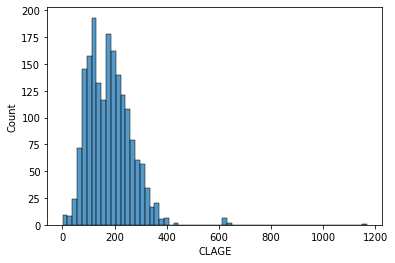

In [ ]:
sns.histplot(dataset.CLAGE)

In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1854 entries, 0 to 1853
Data columns (total 11 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   TARGET   1854 non-null   int64  
 1   LOAN     1854 non-null   int64  
 2   MORTDUE  1854 non-null   float64
 3   VALUE    1854 non-null   float64
 4   YOJ      1854 non-null   float64
 5   DEROG    1854 non-null   float64
 6   DELINQ   1854 non-null   float64
 7   CLAGE    1854 non-null   float64
 8   NINQ     1854 non-null   float64
 9   CLNO     1854 non-null   float64
 10  DEBTINC  1854 non-null   float64
dtypes: float64(9), int64(2)
memory usage: 159.5 KB


Descubrimos que no hay valores nulos en el dataset

In [ ]:
print('El porcentaje de 0s en TARGET es : %.2f' % (dataset['TARGET'].value_counts()[0] / len(dataset)))
print('El porcentaje de 1s en TARGET es : %.2f' % (dataset['TARGET'].value_counts()[1] / len(dataset)))

El porcentaje de 0s en TARGET es : 0.83
El porcentaje de 1s en TARGET es : 0.17


Creemos que la frecuencia de la variable objetivo no es muy útil para poder entrenar el modelo, ya que su conjunto está muy desbalanceado, 5:1.

In [ ]:
X_train.shape

(1483, 10)

In [ ]:
X_test.shape

(371, 10)

In [ ]:
print('El porcentaje de 0s en el conjunto de ENTRENAMIENTO es : %.2f' % (y_train.value_counts()[0] / len(y_train)))
print('El porcentaje de 1s en el conjunto de ENTRENAMIENTO es : %.2f' % (y_train.value_counts()[1] / len(y_train)))

El porcentaje de 0s en el conjunto de ENTRENAMIENTO es : 0.83
El porcentaje de 1s en el conjunto de ENTRENAMIENTO es : 0.17


In [ ]:
print('El porcentaje de 0s en el conjunto de VALIDACION es : %.2f' % (y_test.value_counts()[0] / len(y_test)))
print('El porcentaje de 1s en el conjunto de VALIDACION es : %.2f' % (y_test.value_counts()[1] / len(y_test)))

El porcentaje de 0s en el conjunto de VALIDACION es : 0.84
El porcentaje de 1s en el conjunto de VALIDACION es : 0.16


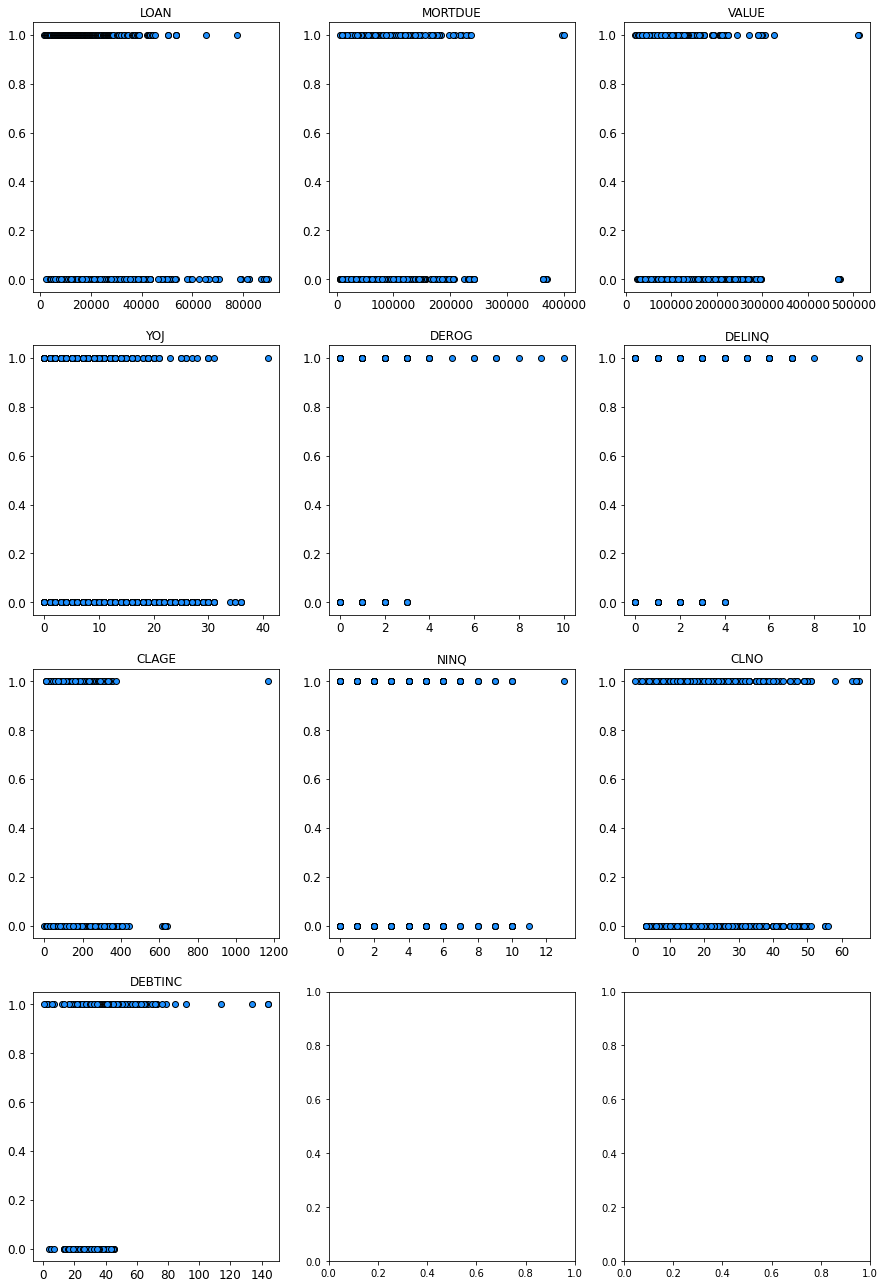

In [ ]:
features = ['LOAN', 'MORTDUE', 'VALUE', 'YOJ', 'DEROG', 'DELINQ', 'CLAGE', 'NINQ', 'CLNO', 'DEBTINC']

plt.subplots(4,3,figsize=(15,16))
plt.subplots_adjust(top=1.2)

for feature in features:
  plt.subplot(4,3,features.index(feature)+1)
  #selector = dataset[feature]
  plt.scatter(
      X[feature], y, 
      facecolor="dodgerblue", 
      edgecolor="k", label="datos"
  )
  plt.title(feature)
  plt.xticks(fontsize=12)
  plt.yticks(fontsize=12)
plt.show()

A primera vista se observa que las variables DEROG, DELINQ, y DEBTINC, son las más determinantes para la predicción.

Vemos sus frecuencias y la correlación en una matriz de calor.

In [ ]:
X.DEROG.value_counts()

0.0     1654
1.0      120
2.0       50
3.0       18
4.0        4
6.0        2
7.0        2
5.0        1
8.0        1
10.0       1
9.0        1
Name: DEROG, dtype: int64

In [ ]:
X.DELINQ.value_counts()

0.0     1539
1.0      181
2.0       71
3.0       30
4.0       12
6.0        7
7.0        6
5.0        6
8.0        1
10.0       1
Name: DELINQ, dtype: int64

In [ ]:
dataset.DELINQ.groupby(dataset.TARGET).value_counts()

TARGET  DELINQ
0       0.0       1345
        1.0        137
        2.0         40
        3.0         19
        4.0          4
1       0.0        194
        1.0         44
        2.0         31
        3.0         11
        4.0          8
        6.0          7
        5.0          6
        7.0          6
        8.0          1
        10.0         1
Name: DELINQ, dtype: int64

In [ ]:
dataset.DEROG.groupby(dataset.TARGET).value_counts()

TARGET  DEROG
0       0.0      1427
        1.0        87
        2.0        27
        3.0         4
1       0.0       227
        1.0        33
        2.0        23
        3.0        14
        4.0         4
        6.0         2
        7.0         2
        5.0         1
        8.0         1
        9.0         1
        10.0        1
Name: DEROG, dtype: int64

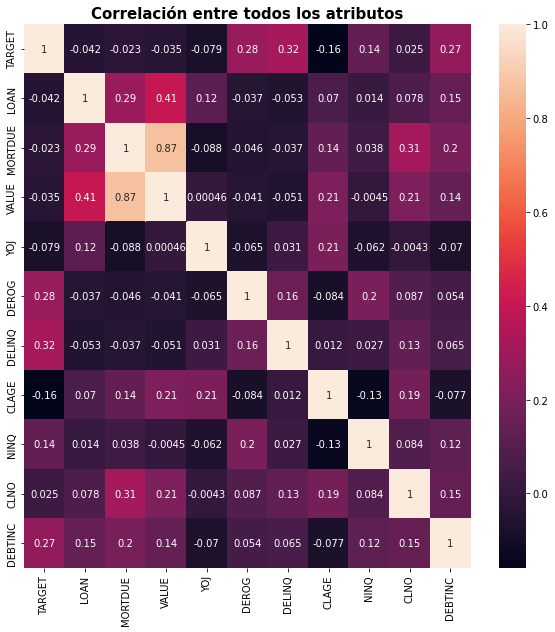

In [ ]:
# Graficamos un mapa de calor
fig = plt.figure(figsize=(10,10))
plt.title('Correlación entre todos los atributos', 
            loc='center', fontsize=15, fontweight='bold'
)
corr_matrix = dataset.corr()
sns.heatmap(corr_matrix, fmt='.2g', annot=True)

A su vez en mapa de color se puede ver que los atributos que mas correlacionan con el TARGET son:
* DELINQ
* DEROG
* DEBTINC

## Ejercicio 2: Predicción con Modelos Lineales

En este ejercicio se entrenarán modelos lineales de clasificación para predecir la variable objetivo.

Para ello, deberán utilizar la clase SGDClassifier de scikit-learn.

Documentación:
- https://scikit-learn.org/stable/modules/sgd.html
- https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html


### Ejercicio 2.1: SGDClassifier con hiperparámetros por defecto

Entrenar y evaluar el clasificador SGDClassifier usando los valores por omisión de scikit-learn para todos los parámetros. Únicamente **fijar la semilla aleatoria** para hacer repetible el experimento.

Evaluar sobre el conjunto de **entrenamiento** y sobre el conjunto de **evaluación**, reportando:
- Accuracy
- Precision
- Recall
- F1
- matriz de confusión

Los clasificadores por descenso de grandiente necesitan que los datos tengan media nula y varianza unitaria. Por lo cual, estandarizamos y escalamos los datos restando la media y escalando a varianza 1.

In [ ]:
scaler = StandardScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# Clasificador lineal con descenso por gradiente estocástico
sgdc = SGDClassifier(random_state=0)
sgdc.fit(X_train_scaled, y_train)

score = sgdc.score(X_train_scaled, y_train)
print("Training accuracy: ", score)

Training accuracy:  0.8732299393122049


Métricas de entrenamiento
-----------------------------
Accuracy = 0.8732299393122049
Precision = 0.7142857142857143
Recall = 0.41832669322709165
F1 = 0.5276381909547739


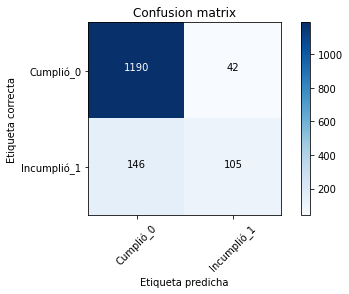

In [ ]:
# Métricas de entrenamiento
y_train_pred = sgdc.predict(X_train_scaled)
print("Métricas de entrenamiento")
print("-----------------------------")

print("Accuracy = %s" % accuracy_score(y_train, y_train_pred))
print("Precision = %s" % precision_score(y_train, y_train_pred))
print("Recall = %s" % recall_score(y_train, y_train_pred))
print("F1 = %s" % f1_score(y_train, y_train_pred))

cm = confusion_matrix(y_train, y_train_pred)
plot_confusion_matrix(cm, ['Cumplió_0', 'Incumplió_1'])

Métricas de validación
-----------------------------
Accuracy = 0.8679245283018868
Precision = 0.6451612903225806
Recall = 0.3448275862068966
F1 = 0.44943820224719105


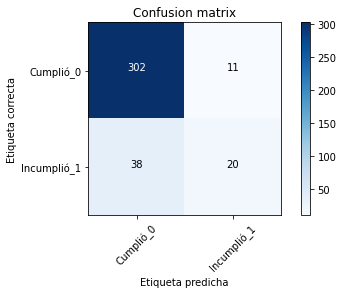

In [ ]:
# Métricas de validación
y_test_pred = sgdc.predict(X_test_scaled)
print("Métricas de validación")
print("-----------------------------")
print("Accuracy = %s" % accuracy_score(y_test, y_test_pred))
print("Precision = %s" % precision_score(y_test, y_test_pred))
print("Recall = %s" % recall_score(y_test, y_test_pred))
print("F1 = %s" % f1_score(y_test, y_test_pred))

cm = confusion_matrix(y_test, y_test_pred)
plot_confusion_matrix(cm, ['Cumplió_0', 'Incumplió_1'])

#### Probaremos con las 3 características más determinantes

In [ ]:
df_selected = pd.DataFrame(dataset, columns=['DEBTINC', 'DELINQ', 'DEROG', 'TARGET'])
df_selected

,DEBTINC,DELINQ,DEROG,TARGET
0,29.209023,0.0,0.0,0
1,31.545694,0.0,0.0,0
2,41.210012,0.0,0.0,0
3,28.602076,0.0,1.0,0
4,30.686106,0.0,0.0,0
...,...,...,...,...
1849,34.558417,0.0,0.0,1
1850,44.945929,0.0,0.0,1
1851,41.646731,1.0,1.0,1
1852,144.189001,0.0,0.0,1


In [ ]:
# División entre instancias y etiquetas
X_1, y_1 = df_selected.iloc[:, 0:2], df_selected.TARGET

# división entre entrenamiento y evaluación
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(
    X_1, y_1, 
    test_size=0.2,
    random_state=0
)

In [ ]:
scaler_1 = StandardScaler()

scaler_1.fit(X_train_1)
X_train_scaled_1 = scaler_1.transform(X_train_1)

X_test_scaled_1 = scaler_1.transform(X_test_1)

In [ ]:
# Clasificador lineal con descenso por gradiente estocástico
sgdc_1 = SGDClassifier(random_state=0)
sgdc_1.fit(X_train_scaled_1, y_train_1)

score_1 = sgdc_1.score(X_train_scaled_1, y_train_1)
print("Training accuracy: ", score_1)

Training accuracy:  0.8610923803101821


Métricas de entrenamiento
-----------------------------
Accuracy = 0.8610923803101821
Precision = 1.0
Recall = 0.17928286852589642
F1 = 0.30405405405405406


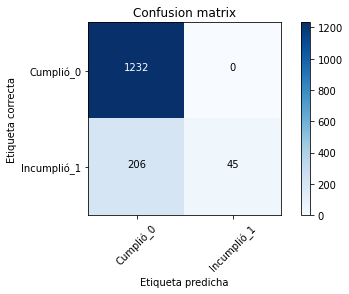

In [ ]:
# Métricas de entrenamiento
y_train_pred_1 = sgdc_1.predict(X_train_scaled_1)
print("Métricas de entrenamiento")
print("-----------------------------")

print("Accuracy = %s" % accuracy_score(y_train_1, y_train_pred_1))
print("Precision = %s" % precision_score(y_train_1, y_train_pred_1))
print("Recall = %s" % recall_score(y_train_1, y_train_pred_1))
print("F1 = %s" % f1_score(y_train_1, y_train_pred_1))

cm1 = confusion_matrix(y_train_1, y_train_pred_1)
plot_confusion_matrix(cm1, ['Cumplió_0', 'Incumplió_1'])

Métricas de validación
-----------------------------
Accuracy = 0.876010781671159
Precision = 1.0
Recall = 0.20689655172413793
F1 = 0.34285714285714286


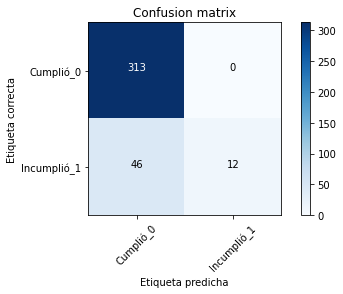

In [ ]:
# Métricas de validación
y_test_pred_1 = sgdc_1.predict(X_test_scaled_1)
print("Métricas de validación")
print("-----------------------------")
print("Accuracy = %s" % accuracy_score(y_test_1, y_test_pred_1))
print("Precision = %s" % precision_score(y_test_1, y_test_pred_1))
print("Recall = %s" % recall_score(y_test_1, y_test_pred_1))
print("F1 = %s" % f1_score(y_test_1, y_test_pred_1))

cm2 = confusion_matrix(y_test_1, y_test_pred_1)
plot_confusion_matrix(cm2, ['Cumplió_0', 'Incumplió_1'])

Vemos que considerando las 3 variables más correlacionadas con el TARGET, prácticamente se invierten los valores de accuracy en los conjuntos de entrenamiento y de validación. 
Con estas 3 variables se alcanza aproximadamente los mismos valores que considerando todas las características. 

### Ejercicio 2.2: Ajuste de Hiperparámetros

Seleccionar valores para los hiperparámetros principales del SGDClassifier. Como mínimo, probar diferentes funciones de loss, tasas de entrenamiento y tasas de regularización.

Para ello, usar grid-search y 5-fold cross-validation sobre el conjunto de entrenamiento para explorar muchas combinaciones posibles de valores.

Reportar accuracy promedio y varianza para todas las configuraciones.

Para la mejor configuración encontrada, evaluar sobre el conjunto de **entrenamiento** y sobre el conjunto de **evaluación**, reportando:
- Accuracy
- Precision
- Recall
- F1
- matriz de confusión

Documentación:
- https://scikit-learn.org/stable/modules/grid_search.html
- https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

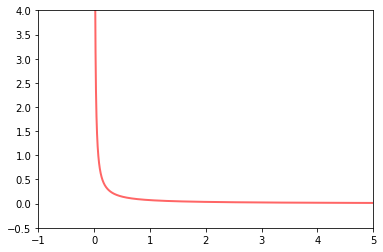

In [ ]:
a = 1e-4
b = 100
fig, ax = plt.subplots(1, 1)
x = np.linspace(a, b, 100000)
plt.xlim(-1, 5)
plt.ylim(-0.50,4)
ax.plot(x, loguniform.pdf(x, a, b), 'r-', lw=2, alpha=0.6, label='loguniform pdf')

En esta función vemos que los valores que tienen mayor probabilidad o valor son los más lejanos al cero, mientras que los que tienen menor valor son los más cercanos al cero. Eso es porque los valores que usamos para el alpha  en la regularización deben ser pequeños, en este caso, entre 0 y 1. Por eso nos parece una función conveniente a utilizar para escoger un rango de valores de alfa.

In [ ]:
a = 1e-4
b = 1e2
x = np.linspace(a, b, 100000) # de 0.0001 a 100.0
fx = loguniform.pdf(x, a, b) 
(x, fx)

(array([1.000000e-04, 1.100009e-03, 2.100018e-03, ..., 9.999800e+01,
        9.999900e+01, 1.000000e+02]),
 array([7.23824137e+02, 6.58016558e+01, 3.44675206e+01, ...,
        7.23838613e-04, 7.23831375e-04, 7.23824137e-04]))

In [ ]:
alphas = [ i for i in fx if -0.50 <= i <= 4 ]

print(len(alphas))

alpha_vals = sample(alphas, 10)
alpha_vals

99982


[0.0009349220965745215,
 0.0008151365552354897,
 0.03019555389234646,
 0.001326545516362619,
 0.007264984012476657,
 0.001970370632173072,
 0.0011674270651523663,
 0.0011858650265041254,
 0.0009126194137967479,
 0.003474530278334626]

In [ ]:
param_grid = {
    'penalty' : ['l2', 'l1'],
    'loss': ['log_loss', 'hinge', 'SVM', 'logistic regression', 'squared_error'], 
    'alpha': alpha_vals,  # de 0.0001 a 100.0
    'learning_rate': ['constant', 'optimal', 'invscaling', 'adaptive'] 
}

In [ ]:
# Validación cruzada con 5-Fold
model = SGDClassifier(random_state=0)
# cv None (default) to use the default 5-fold cross validation
cv = GridSearchCV(model, param_grid, scoring='accuracy') 

cv.fit(X_train_scaled, y_train);

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
1800 fits failed out of a total of 2000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1500 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py", line 892, in fit
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py", line 649, in _fit
    self._validate_params()
  File "/usr/local/lib/pytho

In [ ]:
# Métricas devueltas
cv.cv_results_.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_alpha', 'param_learning_rate', 'param_loss', 'param_penalty', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score'])

In [ ]:
# Reportamos accuracy promedio y varianza para todas las configuraciones
results = cv.cv_results_

df = pd.DataFrame(results)
df[[
    'param_penalty', 
    'param_loss', 
    'param_alpha', 
    'param_learning_rate', 
    'mean_test_score', 
    'std_test_score'
    ]].sort_values(by=['mean_test_score'], ascending=False)

,param_penalty,param_loss,param_alpha,param_learning_rate,mean_test_score,std_test_score
373,l1,hinge,0.003475,optimal,0.871208,0.007791
372,l2,hinge,0.003475,optimal,0.869192,0.009774
213,l1,hinge,0.00197,optimal,0.869192,0.015834
13,l1,hinge,0.000935,optimal,0.869190,0.006422
333,l1,hinge,0.000913,optimal,0.867165,0.010104
...,...,...,...,...,...,...
395,l1,SVM,0.003475,adaptive,NaN,NaN
396,l2,logistic regression,0.003475,adaptive,NaN,NaN
397,l1,logistic regression,0.003475,adaptive,NaN,NaN
398,l2,squared_error,0.003475,adaptive,NaN,NaN


In [ ]:
cv.best_params_

{'alpha': 0.003474530278334626,
 'learning_rate': 'optimal',
 'loss': 'hinge',
 'penalty': 'l1'}

In [ ]:
best_model = cv.best_estimator_

Métricas de entrenamiento
-----------------------------
Accuracy = 0.8705327039784221
Precision = 0.7610619469026548
Recall = 0.3426294820717131
F1 = 0.47252747252747246


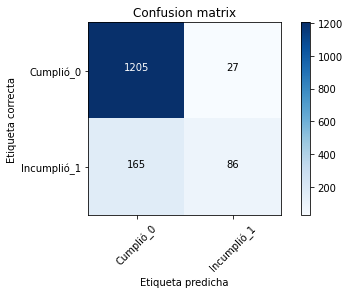

In [ ]:
# Métricas de entrenamiento
y_train_pred = best_model.predict(X_train_scaled)
print("Métricas de entrenamiento")
print("-----------------------------")

print("Accuracy = %s" % accuracy_score(y_train, y_train_pred))
print("Precision = %s" % precision_score(y_train, y_train_pred))
print("Recall = %s" % recall_score(y_train, y_train_pred))
print("F1 = %s" % f1_score(y_train, y_train_pred))

cm = confusion_matrix(y_train, y_train_pred)
plot_confusion_matrix(cm, ['Cumplió_0', 'Incumplió_1'])

Métricas de validación para el mejor ajuste
Accuracy = 0.8733153638814016
Precision = 0.72
Recall = 0.3103448275862069
F1 = 0.4337349397590362


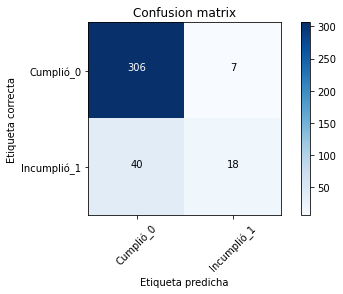

In [ ]:
# Métricas de validación
y_test_pred = best_model.predict(X_test_scaled)
print("Métricas de validación para el mejor ajuste")
print("Accuracy = %s" % accuracy_score(y_test, y_test_pred))
print("Precision = %s" % precision_score(y_test, y_test_pred))
print("Recall = %s" % recall_score(y_test, y_test_pred))
print("F1 = %s" % f1_score(y_test, y_test_pred))

cm = confusion_matrix(y_test, y_test_pred)
plot_confusion_matrix(cm, ['Cumplió_0', 'Incumplió_1'])

### Comparacion y conclusiones



- SGDClassifier por default

Training accuracy:  0.8732299393122049

Accuracy = 0.8679245283018868

- SGDClassifier con hiperparámetros

Training accuracy:  0.8705327039784221

Accuracy = 0.8733153638814016


Vemos que los modelos no difieren mucho en sus metricas, en este caso consideramos que  a este modelo le afecta principalmente el desbalance de datos en nuestra variable target.

## Ejercicio 3: Árboles de Decisión

En este ejercicio se entrenarán árboles de decisión para predecir la variable objetivo.

Para ello, deberán utilizar la clase DecisionTreeClassifier de scikit-learn.

Documentación:
- https://scikit-learn.org/stable/modules/tree.html
- https://scikit-learn.org/stable/modules/tree.html#tips-on-practical-use
- https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
- https://scikit-learn.org/stable/auto_examples/tree/plot_unveil_tree_structure.html

### Ejercicio 3.1: DecisionTreeClassifier con hiperparámetros por defecto

Entrenar y evaluar el clasificador DecisionTreeClassifier usando los valores por omisión de scikit-learn para todos los parámetros. Únicamente **fijar la semilla aleatoria** para hacer repetible el experimento.

Evaluar sobre el conjunto de **entrenamiento** y sobre el conjunto de **evaluación**, reportando:
- Accuracy
- Precision
- Recall
- F1
- matriz de confusión


In [ ]:
clf = DecisionTreeClassifier(random_state=0)

clf.fit(X_train_scaled, y_train)

DecisionTreeClassifier(random_state=0)

Métricas de entrenamiento
-----------------------------
Accuracy = 1.0
Precision = 1.0
Recall = 1.0
F1 = 1.0


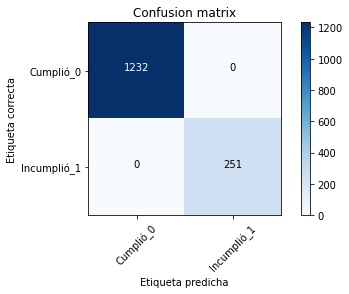

In [ ]:
# Métricas de entrenamiento
y_train_pred = clf.predict(X_train_scaled)
print("Métricas de entrenamiento")
print("-----------------------------")

print("Accuracy = %s" % accuracy_score(y_train, y_train_pred))
print("Precision = %s" % precision_score(y_train, y_train_pred))
print("Recall = %s" % recall_score(y_train, y_train_pred))
print("F1 = %s" % f1_score(y_train, y_train_pred))

cm = confusion_matrix(y_train, y_train_pred)
plot_confusion_matrix(cm, ['Cumplió_0', 'Incumplió_1'])

In [ ]:
predicciones_acertadas = (y_train == y_train_pred).sum()
print('Clasificaciones acertadas:', predicciones_acertadas)
predicciones_erradas = y_train.shape[0] - predicciones_acertadas
print('Clasificaciones erradas:', predicciones_erradas)

Clasificaciones acertadas: 1483
Clasificaciones erradas: 0


Ahora utilizamos al conjunto de validación, X_test_scaled 

In [ ]:
y_test_pred = clf.predict(X_test_scaled)

In [ ]:
predicciones_acertadas = (y_test == y_test_pred).sum()
print('Clasificaciones acertadas:', predicciones_acertadas)
predicciones_erradas = y_test.shape[0] - predicciones_acertadas
print('Clasificaciones erradas:', predicciones_erradas)

Clasificaciones acertadas: 327
Clasificaciones erradas: 44


Métricas de validación para el mejor ajuste
Accuracy = 0.8814016172506739
Precision = 0.6166666666666667
Recall = 0.6379310344827587
F1 = 0.6271186440677966


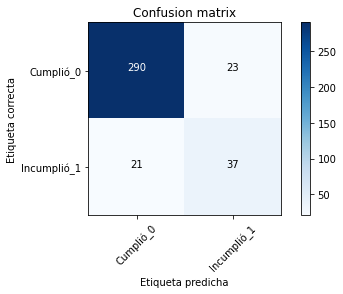

In [ ]:
# Métricas de validación
y_test_pred = clf.predict(X_test_scaled)
print("Métricas de validación para el mejor ajuste")
print("Accuracy = %s" % accuracy_score(y_test, y_test_pred))
print("Precision = %s" % precision_score(y_test, y_test_pred))
print("Recall = %s" % recall_score(y_test, y_test_pred))
print("F1 = %s" % f1_score(y_test, y_test_pred))

cm = confusion_matrix(y_test, y_test_pred)
plot_confusion_matrix(cm, ['Cumplió_0', 'Incumplió_1'])

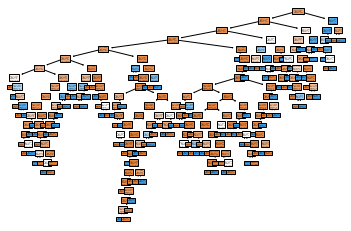

In [ ]:
# Si bien no se visualizan los resultados, 
# se puede dar una idea del árbol inicial
plot_tree(clf,filled=True);

### Ejercicio 3.2: Ajuste de Hiperparámetros

Seleccionar valores para los hiperparámetros principales del DecisionTreeClassifier. Como mínimo, probar diferentes criterios de partición (criterion), profundidad máxima del árbol (max_depth), y cantidad mínima de samples por hoja (min_samples_leaf).

Para ello, usar grid-search y 5-fold cross-validation sobre el conjunto de entrenamiento para explorar muchas combinaciones posibles de valores.

Reportar accuracy promedio y varianza para todas las configuraciones.

Para la mejor configuración encontrada, evaluar sobre el conjunto de **entrenamiento** y sobre el conjunto de **evaluación**, reportando:
- Accuracy
- Precision
- Recall
- F1
- matriz de confusión


Documentación:
- https://scikit-learn.org/stable/modules/grid_search.html
- https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

In [ ]:
param_grid_dt = {
    'criterion' : ['gini', 'entropía', 'log_loss'],
    'max_depth': [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14], 
    'min_samples_leaf': [1, 5, 10, 15, 20],
    'random_state' : [0],
    'ccp_alpha' : [0, 0.2, 0.6, 0.9, 1, 1.3, 2, 5],
    'max_features' : [3, 4, 5, 6, 7, 8]
}

In [ ]:
clf_dt = DecisionTreeClassifier()
# cv None (default) to use the default 5-fold cross validation
cv_dt = GridSearchCV(clf_dt, param_grid_dt, scoring='accuracy')

cv_dt.fit(X_train_scaled, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
28800 fits failed out of a total of 43200.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
14400 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py", line 942, in fit
    X_idx_sorted=X_idx_sorted,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py", line 352, in fit
    criterion = CRITERIA_CLF[self.criterion](
KeyError: 'entropía'

----------------------------

GridSearchCV(estimator=DecisionTreeClassifier(),
             param_grid={'ccp_alpha': [0, 0.2, 0.6, 0.9, 1, 1.3, 2, 5],
                         'criterion': ['gini', 'entropía', 'log_loss'],
                         'max_depth': [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14],
                         'max_features': [3, 4, 5, 6, 7, 8],
                         'min_samples_leaf': [1, 5, 10, 15, 20],
                         'random_state': [0]},
             scoring='accuracy')

In [ ]:
# Reportamos accuracy promedio y varianza para todas las configuraciones
results = cv_dt.cv_results_
df = pd.DataFrame(results)

df[[ 
    'param_ccp_alpha', 
    'param_criterion', 
    'param_max_depth', 
    'param_min_samples_leaf', 
    'param_max_features',
    'mean_test_score', 
    'std_test_score'
    ]].sort_values(by=['mean_test_score'], ascending=False).head(20)

,param_ccp_alpha,param_criterion,param_max_depth,param_min_samples_leaf,param_max_features,mean_test_score,std_test_score
215,0,gini,10,1,4,0.890108,0.022926
136,0,gini,7,5,6,0.890092,0.011762
117,0,gini,6,10,8,0.890092,0.010082
95,0,gini,6,1,4,0.889428,0.015349
195,0,gini,9,1,6,0.888757,0.015398
98,0,gini,6,15,4,0.888084,0.012707
65,0,gini,5,1,4,0.888079,0.019633
135,0,gini,7,1,6,0.888074,0.013796
105,0,gini,6,1,6,0.888061,0.020551
100,0,gini,6,1,5,0.887396,0.010304


In [ ]:
bp = cv_dt.best_params_
bp

{'ccp_alpha': 0,
 'criterion': 'gini',
 'max_depth': 10,
 'max_features': 4,
 'min_samples_leaf': 1,
 'random_state': 0}

In [ ]:
best_model = cv_dt.best_estimator_

In [ ]:
best_model.fit(X_train_scaled, y_train)

DecisionTreeClassifier(ccp_alpha=0, max_depth=10, max_features=4,
                       random_state=0)

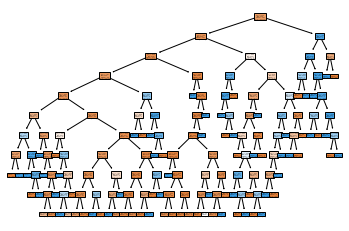

In [ ]:
plot_tree(best_model, filled=True);

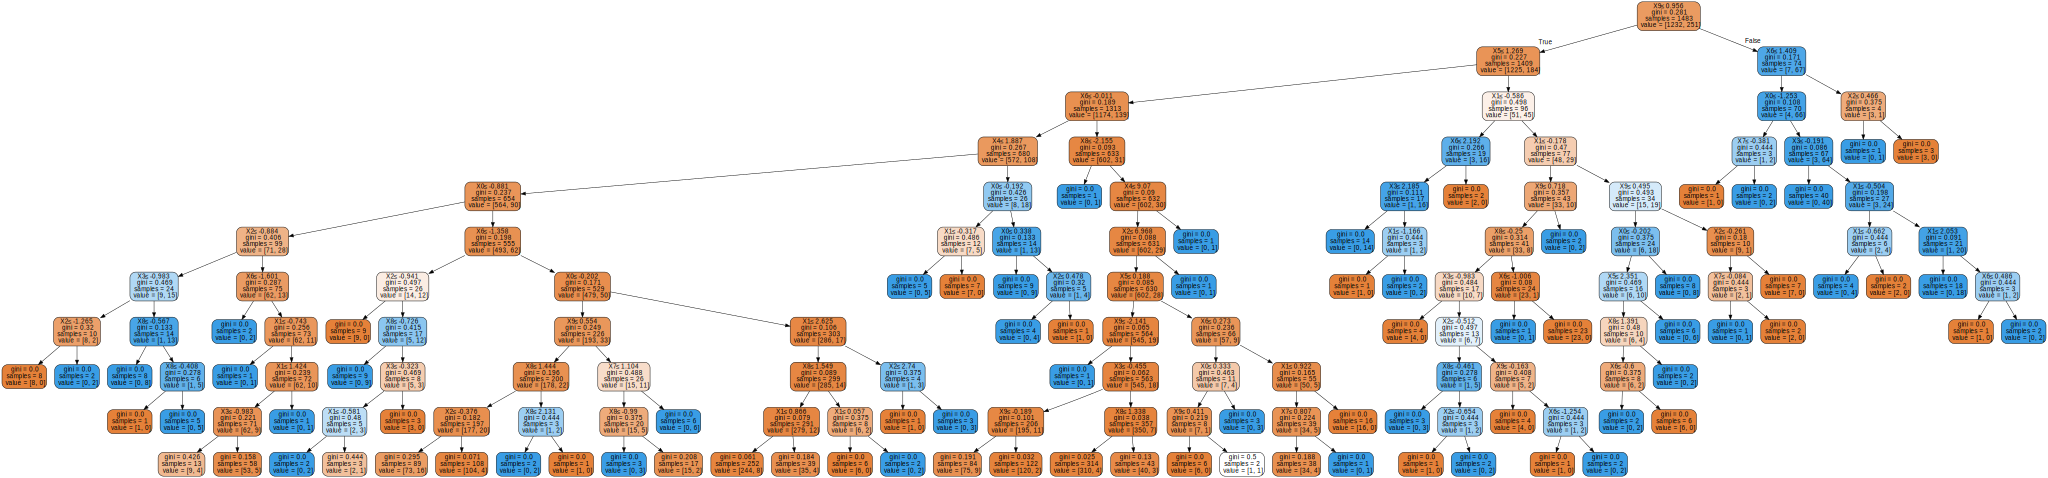

In [ ]:
dot_data = export_graphviz(best_model, out_file=None,
                                filled=True,
                                rounded=True,
                                special_characters=True) 
graph = graphviz.Source(dot_data)  
graph

Metricas de las predicciones de Entrenamiento
---------------------------
Accuracy = 0.9548213081591369
Precision = 1.0
Recall = 0.7330677290836654
F1 = 0.8459770114942529


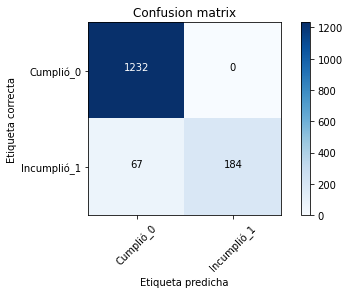

In [ ]:
from sklearn.metrics import accuracy_score

y_train_pred = best_model.predict(X_train_scaled)

print("Metricas de las predicciones de Entrenamiento")
print("---------------------------")
print("Accuracy = %s" % accuracy_score(y_train, y_train_pred))
print("Precision = %s" % precision_score(y_train, y_train_pred))
print("Recall = %s" % recall_score(y_train, y_train_pred))
print("F1 = %s" % f1_score(y_train, y_train_pred))

cm = confusion_matrix(y_train, y_train_pred)
plot_confusion_matrix(cm, ['Cumplió_0', 'Incumplió_1'])

Metricas de las predicciones de Validación
---------------------------
Accuracy = 0.9056603773584906
Precision = 0.7446808510638298
Recall = 0.603448275862069
F1 = 0.6666666666666665


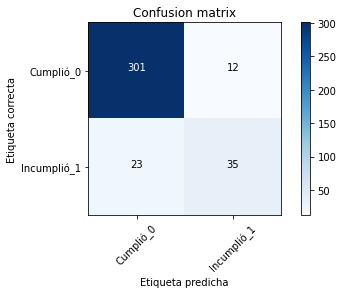

In [ ]:
from sklearn.metrics import accuracy_score

y_test_pred = best_model.predict(X_test_scaled)

print("Metricas de las predicciones de Validación")
print("---------------------------")
print("Accuracy = %s" % accuracy_score(y_test, y_test_pred))
print("Precision = %s" % precision_score(y_test, y_test_pred))
print("Recall = %s" % recall_score(y_test, y_test_pred))
print("F1 = %s" % f1_score(y_test, y_test_pred))

cm = confusion_matrix(y_test, y_test_pred)
plot_confusion_matrix(cm, ['Cumplió_0', 'Incumplió_1'])

 Elegimos el tercer mejor modelo por la cantidad de nodos es menor y  suponemos una mayor y mejor generalizacion.

In [ ]:
clf_best_3 = DecisionTreeClassifier(random_state=0,
                                    max_depth=5,
                                    ccp_alpha=0,
                                    min_samples_leaf=1,
                                    max_features=4,
                                    )

clf_best_3.fit(X_train_scaled, y_train)

DecisionTreeClassifier(ccp_alpha=0, max_depth=5, max_features=4, random_state=0)

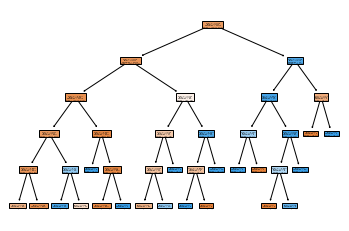

In [ ]:
plot_tree(clf_best_3, filled=True);

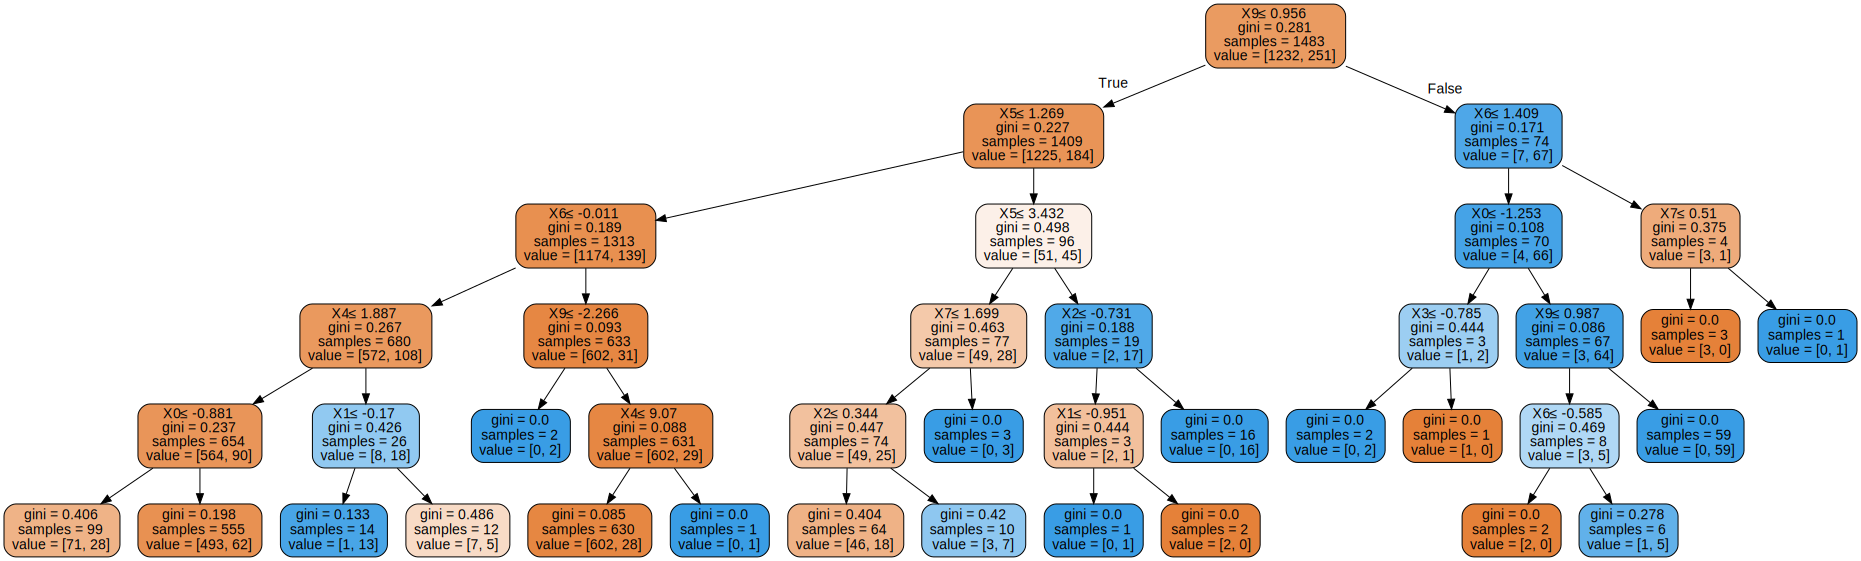

In [ ]:
dot_data_3 = export_graphviz(clf_best_3, out_file=None,
                                filled=True,
                                rounded=True,
                                special_characters=True) 
graph_3 = graphviz.Source(dot_data_3)  
graph_3

Metricas de las predicciones de Entrenamiento
---------------------------
Accuracy = 0.9015509103169251
Precision = 0.9565217391304348
Recall = 0.43824701195219123
F1 = 0.6010928961748634


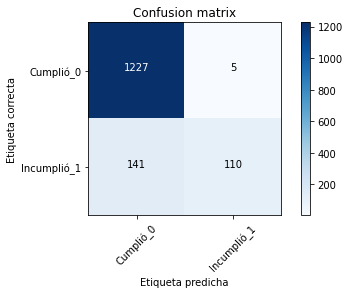

In [ ]:
from sklearn.metrics import accuracy_score

y_train_pred = clf_best_3.predict(X_train_scaled)

print("Metricas de las predicciones de Entrenamiento")
print("---------------------------")
print("Accuracy = %s" % accuracy_score(y_train, y_train_pred))
print("Precision = %s" % precision_score(y_train, y_train_pred))
print("Recall = %s" % recall_score(y_train, y_train_pred))
print("F1 = %s" % f1_score(y_train, y_train_pred))

cm = confusion_matrix(y_train, y_train_pred)
plot_confusion_matrix(cm, ['Cumplió_0', 'Incumplió_1'])

Metricas de las predicciones de Validación
---------------------------
Accuracy = 0.8921832884097035
Precision = 0.8
Recall = 0.41379310344827586
F1 = 0.5454545454545454


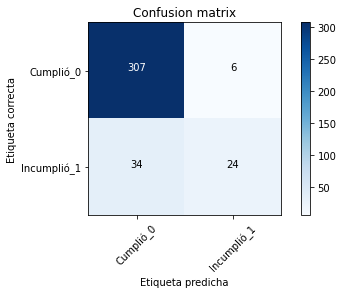

In [ ]:
from sklearn.metrics import accuracy_score

y_test_pred = clf_best_3.predict(X_test_scaled)

print("Metricas de las predicciones de Validación")
print("---------------------------")
print("Accuracy = %s" % accuracy_score(y_test, y_test_pred))
print("Precision = %s" % precision_score(y_test, y_test_pred))
print("Recall = %s" % recall_score(y_test, y_test_pred))
print("F1 = %s" % f1_score(y_test, y_test_pred))

cm = confusion_matrix(y_test, y_test_pred)
plot_confusion_matrix(cm, ['Cumplió_0', 'Incumplió_1'])

### Comparaciones y conclusiones


- DecisionTreeClassifier por default

Training accuracy:  1

Accuracy = 0.8814

- DecisionTreeClassifier con hiperparámetros (Best)

Training accuracy:  0.9548

Accuracy = 0.90566

- DecisionTreeClassifier con hiperparámetros( min_nodos and min_features)

Training accuracy:  0.9015509103169251

Accuracy = 0.8921832884097035


En el caso del modelo con los hiperparámetros seteados por default, vemos como en el entrenamiento se agusta perfectamente a los datos y en la validación el accuracy baja mostrando que no generaliza muy bien los datos, además de tener un arbol muy frondoso.

En el caso del modelo entrenado con los mejores hiperparámetros encontrados en el GridSearch, tenemos un buen accuracy en validación; comparado al primero, es un arbol más podado pero no deja de ser frondoso, por lo que elegimos un tercer modelo.

En el caso del modelo entrenado con los mejores hiperparámetros encontrados en el GridSearch, elegimos el mejor con menos cantidad de nodos y de features para que este sea lo menos frondoso posible y más general. Este nos dio un accuracy bueno. Creemos que por su tamaño es el mejor modelo.
